In [1]:
import torch
import torch.nn as nn
from torch.nn import init
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out

In [3]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=5):
        super(ResNet, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Conv2d):
            init.xavier_uniform_(m.weight)
            if m.bias is not None:
                init.constant_(m.bias, 0)
        elif isinstance(m, nn.Linear):
            init.xavier_uniform_(m.weight)
            init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            init.constant_(m.weight, 1)
            init.constant_(m.bias, 0)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.maxpool(out)

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out

In [4]:
def ResNet34(num_classes=102):
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes=num_classes)

In [5]:
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.Flowers102(root='./data', split='train', download=True, transform=transform_train)
val_dataset = torchvision.datasets.Flowers102(root='./data', split='val', download=True, transform=transform_val)


100%|██████████| 345M/345M [00:02<00:00, 164MB/s]


Extracting data/flowers-102/102flowers.tgz to data/flowers-102


100%|██████████| 502/502 [00:00<00:00, 605kB/s]


100%|██████████| 15.0k/15.0k [00:00<00:00, 42.5MB/s]


In [6]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [17]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

model = ResNet34(num_classes=102).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, verbose=True)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [18]:
num_epochs = 100
train_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_losses.append(train_loss / len(train_loader))

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    val_accuracies.append(accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Accuracy: {accuracy:.2f}%")

Epoch [1/100], Train Loss: 5.2927, Val Accuracy: 3.63%
Epoch [2/100], Train Loss: 4.3428, Val Accuracy: 5.29%
Epoch [3/100], Train Loss: 4.1883, Val Accuracy: 6.76%
Epoch [4/100], Train Loss: 4.0477, Val Accuracy: 9.02%
Epoch [5/100], Train Loss: 3.9380, Val Accuracy: 10.00%
Epoch [6/100], Train Loss: 3.8759, Val Accuracy: 6.27%
Epoch [7/100], Train Loss: 3.7663, Val Accuracy: 9.51%
Epoch [8/100], Train Loss: 3.7082, Val Accuracy: 12.75%
Epoch [9/100], Train Loss: 3.6404, Val Accuracy: 10.88%
Epoch [10/100], Train Loss: 3.5899, Val Accuracy: 15.78%
Epoch [11/100], Train Loss: 3.5375, Val Accuracy: 15.29%
Epoch [12/100], Train Loss: 3.5514, Val Accuracy: 15.78%
Epoch [13/100], Train Loss: 3.4070, Val Accuracy: 18.33%
Epoch [14/100], Train Loss: 3.4351, Val Accuracy: 15.49%
Epoch [15/100], Train Loss: 3.3851, Val Accuracy: 17.94%
Epoch [16/100], Train Loss: 3.2834, Val Accuracy: 16.86%
Epoch [17/100], Train Loss: 3.2268, Val Accuracy: 21.37%
Epoch [18/100], Train Loss: 3.2270, Val Accura

In [48]:
from sklearn.metrics import precision_recall_fscore_support

model.eval()
all_preds = []
all_labels = []
correct = 0
total = 0
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = correct / total
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')

print("------------------------------BASE MODEL------------------------------")
print(f"Final Metrics on Validation Set:")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1 Score: {f1:.4f}")


------------------------------BASE MODEL------------------------------
Final Metrics on Validation Set:
Test Accuracy: 0.8614
Test Precision: 0.8959
Test Recall: 0.8614
Test F1 Score: 0.8636


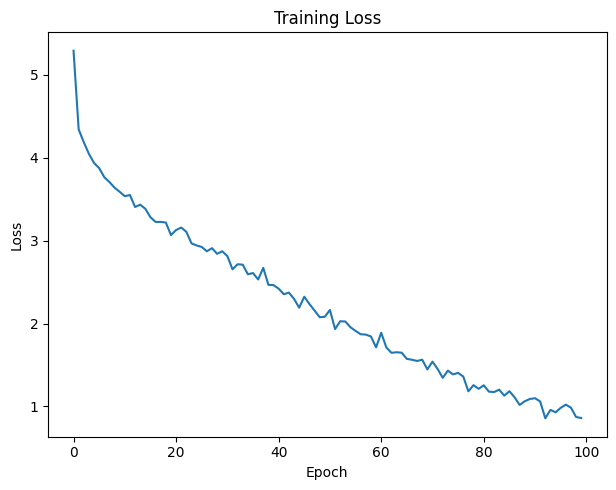

In [49]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.tight_layout()
plt.show()